# Import the essential libraries

In [6]:
# Essential and common packages
import os
import glob

# Read and visualize the raster data
import rasterio
from rasterio.plot import show

# Plots and bars
import matplotlib.pyplot as plt
import seaborn as sns

# Computation library
import numpy as np

# Tensorflow for building the resnet50 model
import tensorflow.python.keras as k
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model

# Sklearn for confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


%matplotlib inline

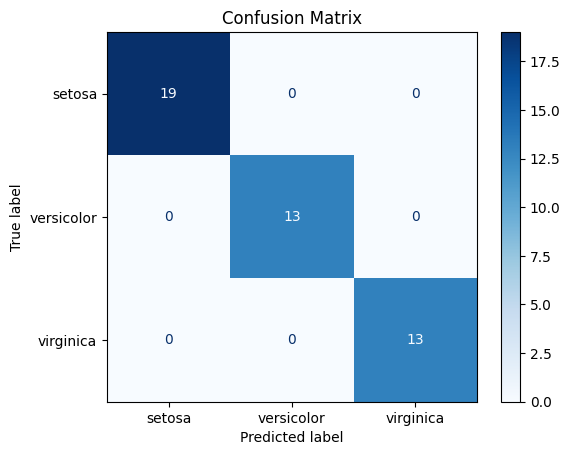

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
class_names = iris.target_names

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [2]:
!pip install rasterio

   ---------------------------------------- 0.0/25.4 MB ? eta -:--:--
   ---------------------------------------- 0.3/25.4 MB ? eta -:--:--
   - -------------------------------------- 1.0/25.4 MB 3.0 MB/s eta 0:00:09
   -- ------------------------------------- 1.8/25.4 MB 3.4 MB/s eta 0:00:08
   --- ------------------------------------ 2.4/25.4 MB 3.4 MB/s eta 0:00:07
   ---- ----------------------------------- 2.9/25.4 MB 3.2 MB/s eta 0:00:08
   ---- ----------------------------------- 3.1/25.4 MB 3.1 MB/s eta 0:00:08
   ----- ---------------------------------- 3.4/25.4 MB 2.8 MB/s eta 0:00:08
   ------ --------------------------------- 3.9/25.4 MB 2.5 MB/s eta 0:00:09
   ------ --------------------------------- 4.2/25.4 MB 2.3 MB/s eta 0:00:10
   ------- -------------------------------- 4.5/25.4 MB 2.3 MB/s eta 0:00:10
   ------- -------------------------------- 5.0/25.4 MB 2.2 MB/s eta 0:00:10
   -------- ------------------------------- 5.2/25.4 MB 2.1 MB/s eta 0:00:10
   -------- -

# Define the required variable

In [8]:
dataset_url = r'E:\object-detect\Geosatelite-image-classification\archive (69)\EuroSAT\geospatial-images'
batch_size = 32
img_height = 64
img_width = 64
validation_split=0.2
rescale=1.0/255

# Data preparation for the model

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=validation_split, rescale=rescale)
dataset = tf.keras.preprocessing.image_dataset_from_directory(dataset_url, image_size=(img_height, img_width), batch_size=batch_size)

Found 27000 files belonging to 10 classes.


In [10]:
train_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="training",
                                           class_mode='categorical')

Found 21600 images belonging to 10 classes.


In [11]:
test_dataset = datagen.flow_from_directory(batch_size=batch_size,
                                           directory=dataset_url,
                                           shuffle=True,
                                           target_size=(img_height, img_width),
                                           subset="validation",
                                           class_mode='categorical')

Found 5400 images belonging to 10 classes.


# Visualization of input datasets

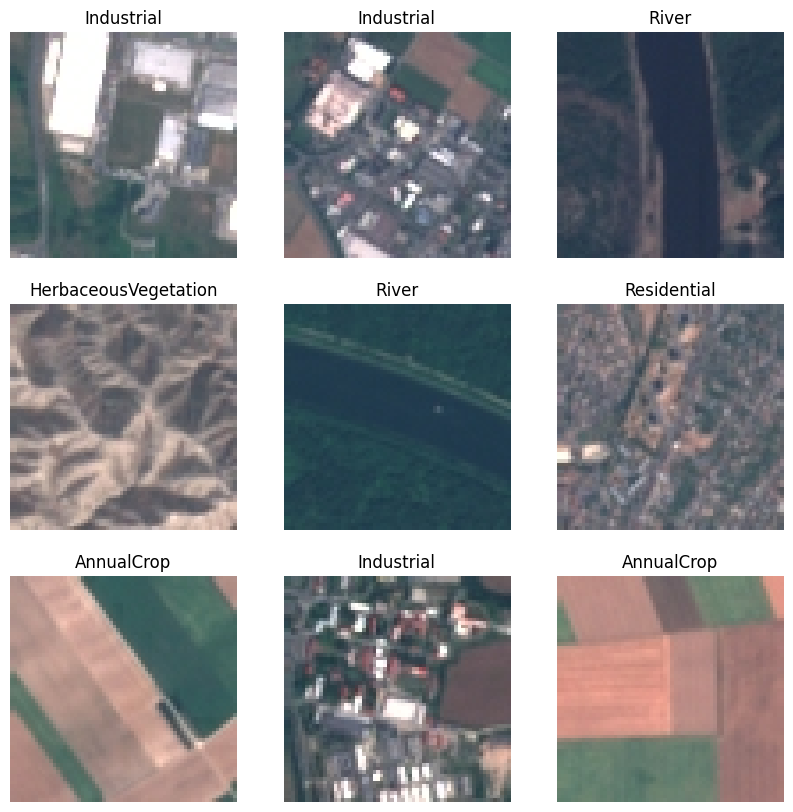

In [12]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# ResNet50 Model building

In [13]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value.
    X_shortcut = X
    cache = []
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training) # Default axis
    X = Activation('relu')(X)
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut, X])
    X = X = Activation('relu')(X, training = training)

    return X

In [14]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    training -- True: Behave in training mode
                False: Behave in inference mode
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    
    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training=training)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X, training = training)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training = training)

    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [15]:
def ResNet50(input_shape = (64, 64, 3), classes = 6):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    
   # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size = (2, 2), name = 'avg_pool')(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

# Model train

In [16]:
model = ResNet50(input_shape=(64,64,3), classes=10)

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# please increase the epoch for higher accuracy (epochs=100)
history = model.fit(train_dataset, validation_data=test_dataset, epochs=20, batch_size=32)


c:\Users\Asus\miniconda3\envs\dl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 1043s 1s/step - accuracy: 0.4211 - loss: 2.0188 - val_accuracy: 0.3694 - val_loss: 2.6004
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 989s 1s/step - accuracy: 0.6634 - loss: 1.0284 - val_accuracy: 0.1928 - val_loss: 169.4894
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 953s 1s/step - accuracy: 0.6233 - loss: 1.2154 - val_accuracy: 0.4457 - val_loss: 4.8493
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 909s 1s/step - accuracy: 0.6827 - loss: 0.9791 - val_accuracy: 0.2680 - val_loss: 15.6899
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 901s 1s/step - accuracy: 0.6507 - loss: 1.0193 - val_accuracy: 0.4470 - val_loss: 1.7932
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 920s 1s/step - accuracy: 0.7214 - loss: 0.8761 - val_accuracy: 0.1735 - val_loss: 397.0336
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 941s 1s/step - accuracy: 0.7443 - loss: 0.7913 - val_accuracy: 0.2139 - val_loss: 5.3209
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 912s 1s/step - accuracy: 0.7622 - loss: 0.7613 - va

In [20]:
#model.save('lulc_20_epoch')
model.save('lulc_20_epoch.keras')


# analyzing results and visualization

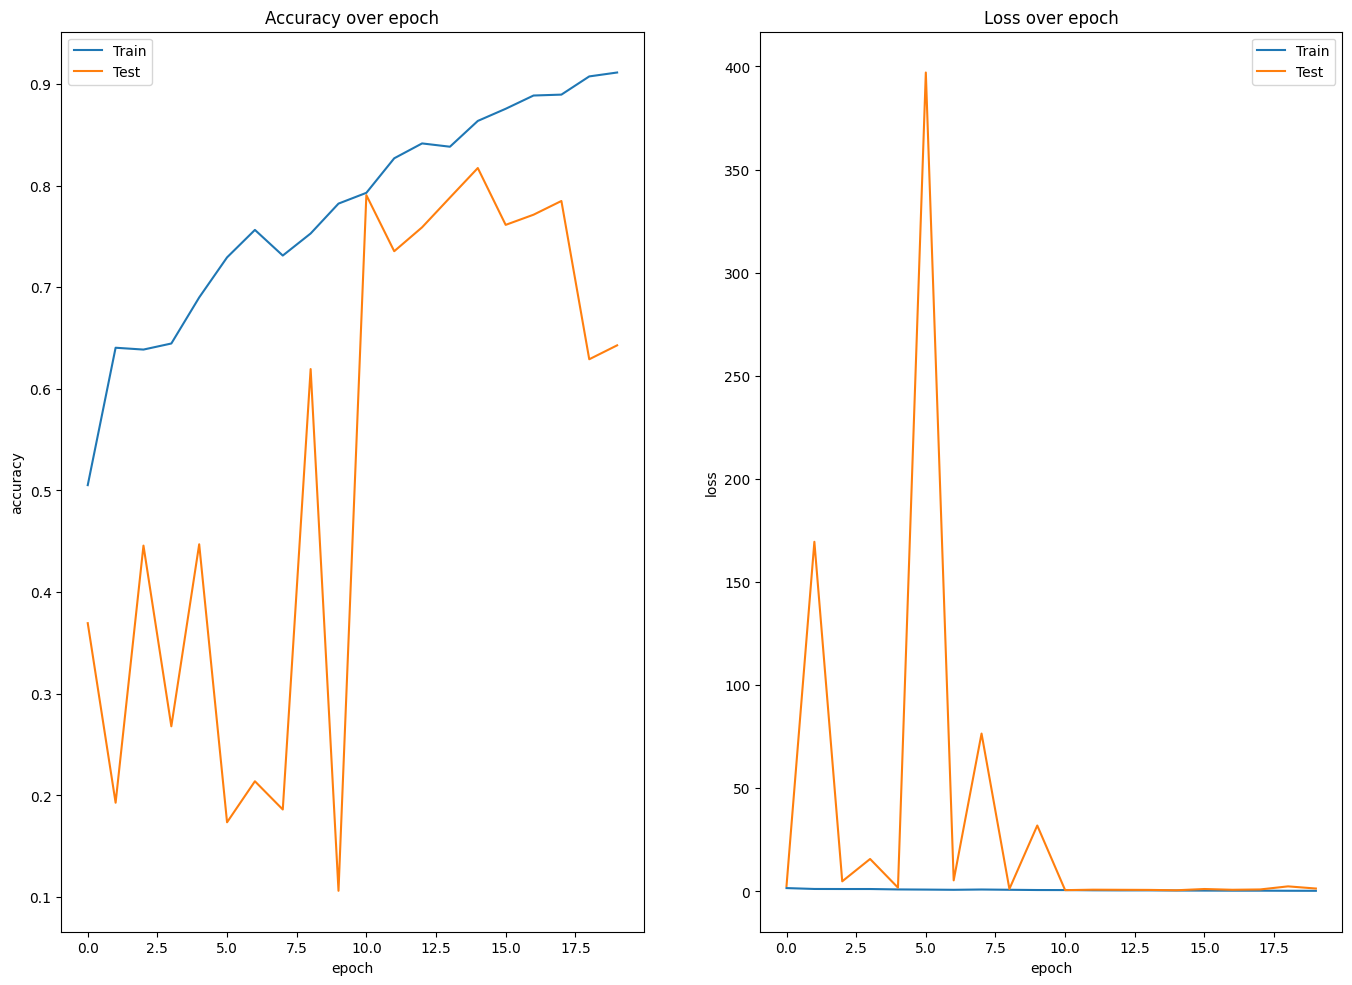

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16.53, 11.69))
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('epoch')
ax1.set_ylabel('accuracy')
ax1.set_title('Accuracy over epoch')
ax1.legend(['Train', 'Test'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Loss over epoch')
ax2.legend(['Train', 'Test'], loc="upper right")

# Confusion matrix

In [22]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for i, (image_batch, label_batch) in enumerate(test_dataset):   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis =  1))
    if i==300:
        break

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
correct_labels = np.argmax(correct_labels, axis=1)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [23]:
cm = confusion_matrix(correct_labels, predicted_labels)
cm

array([[1049,    4,    2,    0,    8,    4,    2,    0,    0,   14],
       [  15,  864,    4,    0,    0,  127,    0,    0,    8,   59],
       [ 502,   44,  263,   17,    7,    5,  167,    2,   31,   15],
       [ 127,    0,    5,  559,   66,    9,   75,    0,   53,    1],
       [   9,    0,    4,   15,  836,    0,   17,    2,    0,    0],
       [ 390,    0,    1,   16,    0,  274,    1,    0,   10,   21],
       [ 501,    0,    0,   11,    9,    0,  349,    0,    9,    0],
       [  11,    0,   64,   81,  195,    0,  389,  331,    0,    0],
       [ 172,    2,    2,   40,    6,   28,    3,    0,  631,   10],
       [  20,    8,    0,    0,    0,    2,    0,    0,    2, 1044]])

In [24]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        figsize=(10, 10),
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1049    4    2    0    8    4    2    0    0   14]
 [  15  864    4    0    0  127    0    0    8   59]
 [ 502   44  263   17    7    5  167    2   31   15]
 [ 127    0    5  559   66    9   75    0   53    1]
 [   9    0    4   15  836    0   17    2    0    0]
 [ 390    0    1   16    0  274    1    0   10   21]
 [ 501    0    0   11    9    0  349    0    9    0]
 [  11    0   64   81  195    0  389  331    0    0]
 [ 172    2    2   40    6   28    3    0  631   10]
 [  20    8    0    0    0    2    0    0    2 1044]]


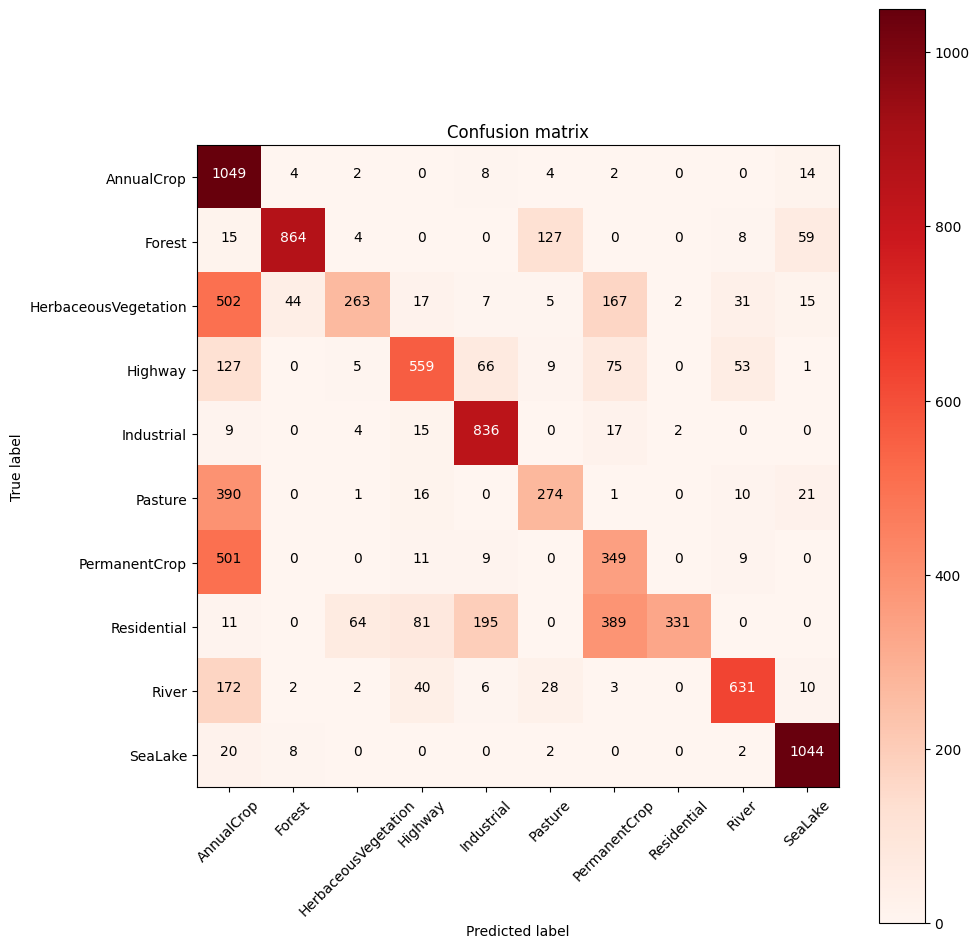

In [25]:
plot_confusion_matrix(cm, train_dataset.class_indices, cmap='Reds')

In [19]:
# model = tf.keras.applications.ResNet101(
#     include_top=False,
#     input_tensor=None,
#     input_shape=(64,64, 3),
#     classes=10,
# )
# model.summary()

# Load model

In [20]:
from tensorflow.keras.models import load_model
model = load_model(r"lulc")

In [26]:
from tensorflow.keras.models import load_model

# Load the model from the 'lulc.keras' file
model = load_model('lulc_20_epoch.keras')


# Thank you 

In [30]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the target size expected by your model
target_size = (64, 64)  # Replace with your model's expected input size

# Load and preprocess the image
img_path = 'E:/object-detect/Geosatelite-image-classification/archive (69)/EuroSAT/PermanentCrop/PermanentCrop_2.jpg'
img = image.load_img(img_path, target_size=target_size)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values if required

# Perform inference
predictions = model.predict(img_array)
print(predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[9.3412149e-01 7.8758183e-07 7.9210899e-05 1.7979777e-05 6.7318076e-08
  5.1259096e-05 6.5161079e-02 1.8691455e-08 5.6701922e-04 9.4689437e-07]]


In [36]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('lulc_20_epoch.keras')

# Define the class labels (Replace with your actual class names)
class_labels = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
                'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# Load and preprocess the image
img_path = 'E:/object-detect/Geosatelite-image-classification/archive (69)/EuroSAT/Highway/Highway_7.jpg/'
img = image.load_img(img_path, target_size=(64, 64))  # Resize to model's expected input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize to [0, 1] range

# Perform inference
predictions = model.predict(img_array)

# Get the predicted class
predicted_class_index = np.argmax(predictions, axis=-1)[0]
predicted_label = class_labels[predicted_class_index]

# Display the prediction
print(f'Predicted class index: {predicted_class_index}')
print(f'Predicted class: {predicted_label}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class index: 3
Predicted class: Highway
